# Importing libraries

In [111]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# width of the print
np.set_printoptions(linewidth=300)

In [ ]:
# Simple LSTM Many to One Example on a Logistic Curve with a single feature 
# Data is generated from a logistic curve witn no noise, 
# goal is to make model learn the logistic curve


# Data generation

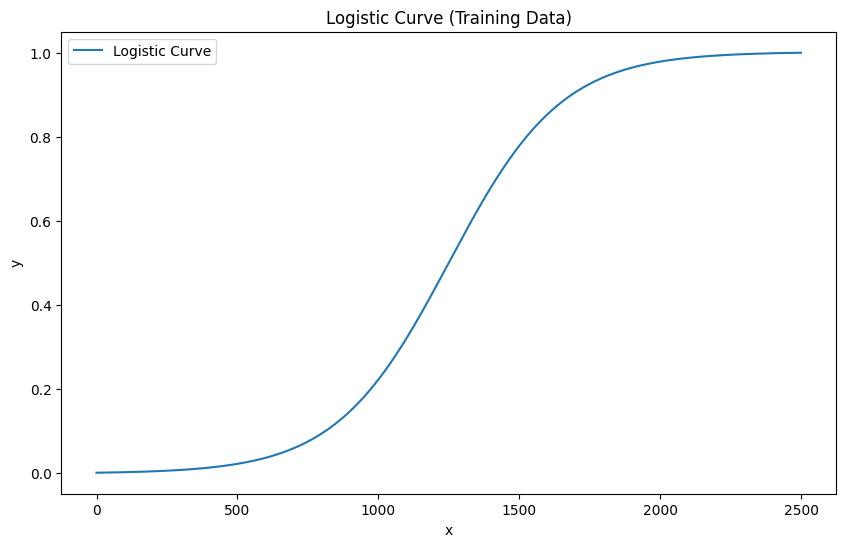

In [93]:
# Logistic function
def logistic_curve(x, L, k, x0, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Generate data
x_train = np.linspace(0, 2500, 2500)  # x-axis points
L, k, x0, b = 1, 0.005, 1250, 1       # Parameters for logistic curve
y_train = logistic_curve(x_train, L, k, x0, b)

# Total data size
data_size = len(y_train)

# Normalize the data
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()

# Keep 100% of data for training
train_data = y_train_scaled

# Percentage of data to use for val and test
val_percentage = 0.2
test_percentage = 0.1

val_size = int(len(train_data) * val_percentage)
test_size = int(len(train_data) * test_percentage)

# Validation set is the last `val_size` points of the training data
val_data = train_data[-(val_size + test_size):-test_size]
test_data = train_data[-test_size:]

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train_scaled, label="Logistic Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Logistic Curve (Training Data)")
plt.legend()
plt.show()

# Data preparation pytorch *Dataset* and *DataLoader*

In [94]:

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len):
        """
        Parameters:
        - data: 1D array or list of time series data.
        - seq_len: Length of input sequences.
        """

        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        # Handle edge case where data is too short
        return max(0, len(self.data) - self.seq_len)

    def __getitem__(self, idx):
        """
        Returns:
        - x: Input sequence of shape (seq_len, 1).
        - y: Target value (scalar).
        """
        x = self.data[idx:idx + self.seq_len]  # Input sequence
        y = self.data[idx + self.seq_len]  # Target (next value)
        return x.unsqueeze(-1), y.unsqueeze(-1)  # Add feature dim for LSTM

    def visualize_sample(self, idx):
        """
        Visualizes a single sample from the dataset.
        Prints input sequence and target value.
        """
        x, y = self[idx]
        print(f"Input sequence (x): {x.squeeze().numpy()}")
        print(f"Target (y): {y.item()}")
    
    def plot_sample(self, idx):
        """
        Plots the input sequence and the target value for a single sample.
        """
        x, y = self[idx]
        x = x.squeeze().numpy()  # Remove extra dimensions for plotting
        y = y.item()  # Convert target to scalar

        plt.figure(figsize=(8, 4))
        plt.plot(range(len(x)), x, label="Input Sequence", marker="o")
        # plt.axhline(y, color="red", linestyle="--", label="Target Value")
        plt.scatter(len(x), y, color = "red",  label="Target Value", marker="o")
        plt.xlabel("Time Steps")
        plt.ylabel("Normalized Value")
        plt.title(f"Sample {idx}: Input Sequence and Target")
        plt.legend()
        plt.show()

seq_len = 50

train_dataset = TimeSeriesDataset(y_train_scaled, seq_len)
val_dataset = TimeSeriesDataset(val_data, seq_len)
test_dataset = TimeSeriesDataset(test_data, seq_len)


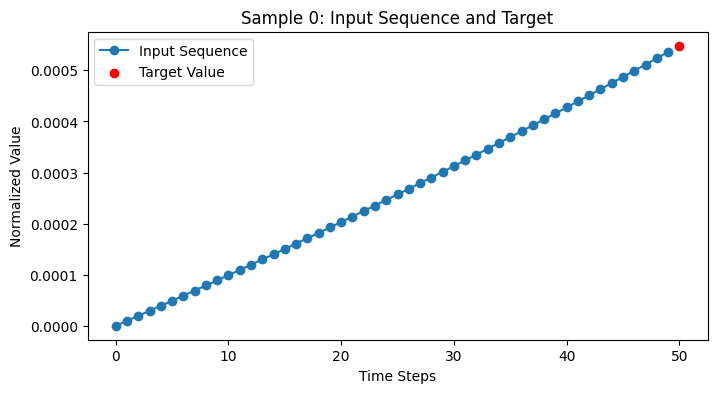

In [95]:
train_dataset.plot_sample(0)

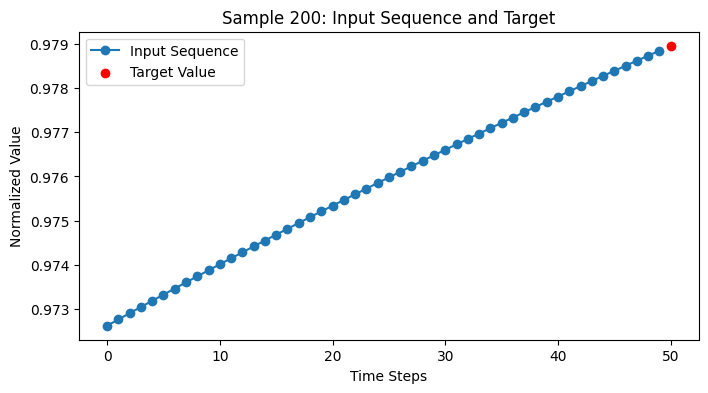

In [96]:
val_dataset.plot_sample(200)


In [97]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [98]:
print(f"Training Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

Training Dataset: 2450 samples
Validation Dataset: 450 samples
Test Dataset: 200 samples


# Model definition

In [112]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output one value (next point)
    
    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM layer
        out = self.fc(out[:, -1, :])  # Fully connected layer on last time step
        return out


In [113]:

# Define model
input_size = 1  # Single feature
hidden_size = 10  # Number of LSTM units
num_layers = 1  # Single LSTM layer
# Learning rate
learning_rate = 0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Training loop with validation

In [114]:

num_epochs = 50
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for x_batch_train, y_batch_train in tqdm(train_dataloader, desc=f"T Eph {epoch+1}/{num_epochs}"):
        x_batch_train, y_batch_train = x_batch_train.to(device), y_batch_train.to(device)
        optimizer.zero_grad()
        predictions = model(x_batch_train)
        loss = criterion(predictions, y_batch_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch_val, y_batch_val in tqdm(val_dataloader, desc=f"V Eph {epoch+1}/{num_epochs}"):
            x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
            predictions = model(x_batch_val)
            loss = criterion(predictions, y_batch_val)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, T Loss: {train_loss:.12f}, V Loss: {val_loss:.12f}")


V Eph 1/50: 100%|██████████| 15/15 [00:00<00:00, 1085.97it/s]


Epoch 1/50, T Loss: 0.127490039576, V Loss: 0.040443711728


V Eph 2/50: 100%|██████████| 15/15 [00:00<00:00, 1040.94it/s]


Epoch 2/50, T Loss: 0.009943465566, V Loss: 0.000061732238


V Eph 3/50: 100%|██████████| 15/15 [00:00<00:00, 876.85it/s]


Epoch 3/50, T Loss: 0.001471209034, V Loss: 0.000133768231


V Eph 4/50: 100%|██████████| 15/15 [00:00<00:00, 968.50it/s]


Epoch 4/50, T Loss: 0.000905882480, V Loss: 0.000205839656


V Eph 5/50: 100%|██████████| 15/15 [00:00<00:00, 1011.20it/s]


Epoch 5/50, T Loss: 0.000557188648, V Loss: 0.000126663398


V Eph 6/50: 100%|██████████| 15/15 [00:00<00:00, 918.78it/s]


Epoch 6/50, T Loss: 0.000297106010, V Loss: 0.000039692681


V Eph 7/50: 100%|██████████| 15/15 [00:00<00:00, 691.73it/s]


Epoch 7/50, T Loss: 0.000131693729, V Loss: 0.000000171252


V Eph 8/50: 100%|██████████| 15/15 [00:00<00:00, 997.38it/s]


Epoch 8/50, T Loss: 0.000067368382, V Loss: 0.000004639995


V Eph 9/50: 100%|██████████| 15/15 [00:00<00:00, 758.22it/s]


Epoch 9/50, T Loss: 0.000048748183, V Loss: 0.000000240380


V Eph 10/50: 100%|██████████| 15/15 [00:00<00:00, 1054.57it/s]


Epoch 10/50, T Loss: 0.000038039345, V Loss: 0.000001217721


V Eph 11/50: 100%|██████████| 15/15 [00:00<00:00, 650.20it/s]


Epoch 11/50, T Loss: 0.000030423047, V Loss: 0.000004260397


V Eph 12/50: 100%|██████████| 15/15 [00:00<00:00, 707.72it/s]


Epoch 12/50, T Loss: 0.000025674294, V Loss: 0.000000936342


V Eph 13/50: 100%|██████████| 15/15 [00:00<00:00, 779.46it/s]


Epoch 13/50, T Loss: 0.000021615326, V Loss: 0.000009932715


V Eph 14/50: 100%|██████████| 15/15 [00:00<00:00, 902.89it/s]


Epoch 14/50, T Loss: 0.000019212908, V Loss: 0.000002129756


V Eph 15/50: 100%|██████████| 15/15 [00:00<00:00, 1725.34it/s]


Epoch 15/50, T Loss: 0.000015848013, V Loss: 0.000002054323


V Eph 16/50: 100%|██████████| 15/15 [00:00<00:00, 746.63it/s]


Epoch 16/50, T Loss: 0.000014776348, V Loss: 0.000006968285


V Eph 17/50: 100%|██████████| 15/15 [00:00<00:00, 656.43it/s]


Epoch 17/50, T Loss: 0.000013462036, V Loss: 0.000003642358


V Eph 18/50: 100%|██████████| 15/15 [00:00<00:00, 1049.77it/s]


Epoch 18/50, T Loss: 0.000013024231, V Loss: 0.000004297034


V Eph 19/50: 100%|██████████| 15/15 [00:00<00:00, 744.89it/s]


Epoch 19/50, T Loss: 0.000012578383, V Loss: 0.000007239448


V Eph 20/50: 100%|██████████| 15/15 [00:00<00:00, 777.52it/s]


Epoch 20/50, T Loss: 0.000011029781, V Loss: 0.000003557376


V Eph 21/50: 100%|██████████| 15/15 [00:00<00:00, 1058.28it/s]


Epoch 21/50, T Loss: 0.000010174292, V Loss: 0.000002523719


V Eph 22/50: 100%|██████████| 15/15 [00:00<00:00, 1248.75it/s]


Epoch 22/50, T Loss: 0.000010111195, V Loss: 0.000002601250


V Eph 23/50: 100%|██████████| 15/15 [00:00<00:00, 801.46it/s]


Epoch 23/50, T Loss: 0.000009027606, V Loss: 0.000002860879


V Eph 24/50: 100%|██████████| 15/15 [00:00<00:00, 618.64it/s]


Epoch 24/50, T Loss: 0.000008799671, V Loss: 0.000003562884


V Eph 25/50: 100%|██████████| 15/15 [00:00<00:00, 782.86it/s]


Epoch 25/50, T Loss: 0.000008594657, V Loss: 0.000007496760


V Eph 26/50: 100%|██████████| 15/15 [00:00<00:00, 801.49it/s]


Epoch 26/50, T Loss: 0.000007821319, V Loss: 0.000002202395


V Eph 27/50: 100%|██████████| 15/15 [00:00<00:00, 839.88it/s]


Epoch 27/50, T Loss: 0.000007297146, V Loss: 0.000007930376


V Eph 28/50: 100%|██████████| 15/15 [00:00<00:00, 758.18it/s]


Epoch 28/50, T Loss: 0.000007674153, V Loss: 0.000002282474


V Eph 29/50: 100%|██████████| 15/15 [00:00<00:00, 882.10it/s]


Epoch 29/50, T Loss: 0.000006916218, V Loss: 0.000005267945


V Eph 30/50: 100%|██████████| 15/15 [00:00<00:00, 1495.19it/s]


Epoch 30/50, T Loss: 0.000006284457, V Loss: 0.000002487346


V Eph 31/50: 100%|██████████| 15/15 [00:00<00:00, 930.37it/s]


Epoch 31/50, T Loss: 0.000007245279, V Loss: 0.000002725445


V Eph 32/50: 100%|██████████| 15/15 [00:00<00:00, 958.99it/s]


Epoch 32/50, T Loss: 0.000006206751, V Loss: 0.000006382945


V Eph 33/50: 100%|██████████| 15/15 [00:00<00:00, 786.80it/s]


Epoch 33/50, T Loss: 0.000005370676, V Loss: 0.000002089495


V Eph 34/50: 100%|██████████| 15/15 [00:00<00:00, 1002.93it/s]


Epoch 34/50, T Loss: 0.000005119607, V Loss: 0.000004404640


V Eph 35/50: 100%|██████████| 15/15 [00:00<00:00, 976.42it/s]


Epoch 35/50, T Loss: 0.000005236509, V Loss: 0.000002026268


V Eph 36/50: 100%|██████████| 15/15 [00:00<00:00, 1274.43it/s]


Epoch 36/50, T Loss: 0.000005034888, V Loss: 0.000002574614


V Eph 37/50: 100%|██████████| 15/15 [00:00<00:00, 897.29it/s]


Epoch 37/50, T Loss: 0.000004659136, V Loss: 0.000002602047


V Eph 38/50: 100%|██████████| 15/15 [00:00<00:00, 798.51it/s]


Epoch 38/50, T Loss: 0.000005065686, V Loss: 0.000001960499


V Eph 39/50: 100%|██████████| 15/15 [00:00<00:00, 905.06it/s]


Epoch 39/50, T Loss: 0.000004435621, V Loss: 0.000003582827


V Eph 40/50: 100%|██████████| 15/15 [00:00<00:00, 936.33it/s]


Epoch 40/50, T Loss: 0.000004617249, V Loss: 0.000006546532


V Eph 41/50: 100%|██████████| 15/15 [00:00<00:00, 984.27it/s]


Epoch 41/50, T Loss: 0.000004441033, V Loss: 0.000001293391


V Eph 42/50: 100%|██████████| 15/15 [00:00<00:00, 944.27it/s]


Epoch 42/50, T Loss: 0.000004737436, V Loss: 0.000001256892


V Eph 43/50: 100%|██████████| 15/15 [00:00<00:00, 896.05it/s]


Epoch 43/50, T Loss: 0.000004356608, V Loss: 0.000007179950


V Eph 44/50: 100%|██████████| 15/15 [00:00<00:00, 808.97it/s]


Epoch 44/50, T Loss: 0.000004050021, V Loss: 0.000002132901


V Eph 45/50: 100%|██████████| 15/15 [00:00<00:00, 974.00it/s]


Epoch 45/50, T Loss: 0.000003546191, V Loss: 0.000010765728


V Eph 46/50: 100%|██████████| 15/15 [00:00<00:00, 597.69it/s]


Epoch 46/50, T Loss: 0.000003441199, V Loss: 0.000003785338


V Eph 47/50: 100%|██████████| 15/15 [00:00<00:00, 747.15it/s]


Epoch 47/50, T Loss: 0.000003178679, V Loss: 0.000000809392


V Eph 48/50: 100%|██████████| 15/15 [00:00<00:00, 740.55it/s]


Epoch 48/50, T Loss: 0.000003172789, V Loss: 0.000001658844


V Eph 49/50: 100%|██████████| 15/15 [00:00<00:00, 701.95it/s]


Epoch 49/50, T Loss: 0.000003644713, V Loss: 0.000001732509


V Eph 50/50: 100%|██████████| 15/15 [00:00<00:00, 971.97it/s]

Epoch 50/50, T Loss: 0.000004186098, V Loss: 0.000002541179


# Test loop


Test Loss: 0.000000


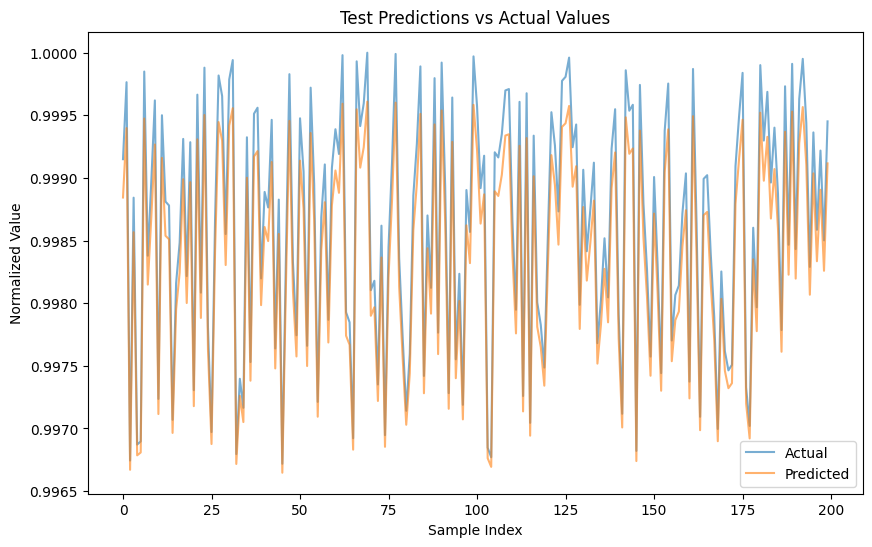

In [115]:
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for x_batch_test, y_batch_test in test_dataloader:
        x_batch_test, y_batch_test = x_batch_test.to(device), y_batch_test.to(device)
        predictions = model(x_batch_test)
        test_loss += criterion(predictions, y_batch_test).item()
        test_predictions.extend(predictions.cpu().numpy())
        test_targets.extend(y_batch_test.cpu().numpy())

test_loss /= len(test_dataloader)
print(f"Test Loss: {test_loss:.6f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(test_targets, label="Actual", alpha=0.6)
plt.plot(test_predictions, label="Predicted", alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Normalized Value")
plt.legend()
plt.title("Test Predictions vs Actual Values")
plt.show()


In [116]:
print(f"Test Targets and Predictions: {test_targets[:10]} {test_predictions[:10]}")



Test Targets and Predictions: [array([0.9991499], dtype=float32), array([0.9997647], dtype=float32), array([0.9967437], dtype=float32), array([0.9988425], dtype=float32), array([0.99687123], dtype=float32), array([0.9968964], dtype=float32), array([0.9998496], dtype=float32), array([0.99837935], dtype=float32), array([0.9989782], dtype=float32), array([0.99961925], dtype=float32)] [array([0.99884397], dtype=float32), array([0.99939805], dtype=float32), array([0.99666965], dtype=float32), array([0.99856657], dtype=float32), array([0.9967851], dtype=float32), array([0.9968078], dtype=float32), array([0.9994746], dtype=float32), array([0.99814856], dtype=float32), array([0.99868906], dtype=float32), array([0.99926704], dtype=float32)]
